In [1]:
from sympy import *
import numpy as np
from scipy.special import airy
from scipy.integrate import quad
import matplotlib.pyplot as plt
from collections.abc import Iterable
import ipywidgets as widgets

In [2]:
t = symbols('t', positive=True)

def w(t):
    """
    Frequency term in the ODE x'' + w(t)^2x = 0.
    """
    # Airy
    return sqrt(t)
    # Burst
    #return sqrt(m**2 - 1)/(1 + t**2) 

def dsum_Barnett(n, t):
    """
    Sum of the first (n+1) terms in the Barnett series, which approximates 
    u(t) following the sequence of substitutions below:
    x'' + w(t)^2x = 0,
    let x = e^z,
    let z' = u.
    """
    if n == 0:
        return 1j*w(t)
    else:
        return Rational(1,2)*(-diff(dsum_Barnett(Integer(n-1), t), t)/dsum_Barnett(Integer(n-1), t) +\
                    dsum_Barnett(Integer(n-1), t) - w(t)**Integer(2)/dsum_Barnett(Integer(n-1), t))
    
def dS_WKB(n, t):
    """
    Derivative of the (n+1)th term in the WKB series. 
    """
    if n == 0:
        return 1j*w(t)
    else:
        sums = 0.0
        for i in range(1, n):
            sums += dS_WKB(i,t)*dS_WKB(n-i, t)
        return -1/(2*dS_WKB(0, t))*(diff(dS_WKB(n-1, t), t) + sums)
    
def sum_dS_WKB(n, t):
    """
    Sum of the derivatives of the first (n+1) terms in the WKB series.
    """
    sums = 0.0
    for i in range(n+1):
        sums += dS_WKB(i, t)
    return sums

def eval_Barnett(n, ts, x0, dx0):
    """
    Evaluates the Barnett series approximation to x(t) at a sequence of
    points ts, starting from initial condititions x(t[0]) = x0,
    x'(t[0]) = dx0.
    """
    t0 = ts[0]
    dBarnett = dsum_Barnett(n, t)
    dBarnett_re = re(dBarnett)
    dBarnett_im = im(dBarnett)
    # The next two lines work if sympy can work out the integral analytically
    #Barnett = integrate(dBarnett, t)
    #Barnett_lambda = lambdify(t, Barnett, 'numpy')
    # Otherwise, just brute-force compute it 
    dBarnett_lambda = lambdify(t, dBarnett, 'numpy')
    dBarnett_lambda_re = lambdify(t, dBarnett_re, 'numpy')
    dBarnett_lambda_im = lambdify(t, dBarnett_im, 'numpy')
    Barnett_lambda = lambda us: np.array([quad(dBarnett_lambda_re, t0, u)[0] +\
                                          1j*quad(dBarnett_lambda_im, t0, u)[0] for u in us])\
                                          if isinstance(us, Iterable) else quad(dBarnett_lambda_re, t0, us)[0] +\
                                          1j*quad(dBarnett_lambda_im, t0, us)[0]
                                    
    fp = np.exp(Barnett_lambda(ts) - Barnett_lambda(t0))
    fm = np.conj(fp)
    dfp0 =  dBarnett_lambda(t0)
    dfm0 = np.conj(dfp0)
    Ap = (dx0 - x0*dfm0)/(dfp0 - dfm0)
    Am = (dx0 - x0*dfp0)/(dfm0 - dfp0)
    result = Ap*fp + Am*fm
    return result
    
def eval_WKB(n, ts, x0, dx0):
    """
    Evaluates the WKB approximation to x(t) at a sequence of points ts,
    starting from initial condititions x(t[0]) = x0, x'(t[0]) = dx0.
    """
    t0 = ts[0]
    dWKB = sum_dS_WKB(n, t)
    WKB = integrate(dWKB, t)
    WKB_lambda = lambdify(t, WKB, 'numpy')
    dWKB_lambda = lambdify(t, dWKB, 'numpy')
    fp = np.exp(WKB_lambda(ts) - WKB_lambda(t0))
    fm = np.conj(fp)
    dfp0 =  dWKB_lambda(t0)
    dfm0 = np.conj(dfp0)
    Ap = (dx0 - x0*dfm0)/(dfp0 - dfm0)
    Am = (dx0 - x0*dfp0)/(dfm0 - dfp0)
    result = Ap*fp + Am*fm
    return result    

In [325]:
def burst(t):
    return np.sqrt(1.+t**2)/m*(np.cos(m*np.arctan(t)))

def dburst(t):
    return 1/(m*np.sqrt(1+t**2))*(t*np.cos(m*np.arctan(t))-m*np.sin(m*np.arctan(t)))

In [ ]:
n = 5
m = 100
ts = np.linspace(0, 30, 100)
xs_ana = burst(ts)
x0 = xs_ana[0]
dx0 = dburst(ts[0])
xs_Barnett = eval_Barnett(n, ts, x0, dx0)
xs_WKB = eval_WKB(2, ts, x0, dx0)

err_Barnett = np.abs(xs_Barnett - xs_ana)
err_WKB = np.abs(xs_WKB - xs_ana)

print('Maximum errors:')
print('WKB: ', max(err_WKB))
print('Barnett: ', max(err_Barnett))

In [318]:
n = 3
m = 100
ts = np.linspace(0, 30, 1000)
xs_ana = np.array([airy(-ti)[0] + 1j*airy(-ti)[2] for ti in ts])
x0 = xs_ana[0]
dx0 = -airy(-ts[0])[1] - 1j*airy(-ts[0])[3]
xs_Barnett = eval_Barnett(n, ts, x0, dx0)
xs_WKB = eval_WKB(n, ts, x0, dx0)

#err_Barnett = np.abs(xs_Barnett - xs_ana)
#err_WKB = np.abs(xs_WKB - xs_ana)

#print('Maximum errors:')
#print('WKB: ', max(err_WKB))
#print('Barnett: ', max(err_Barnett))

<IPython.core.display.Javascript object>


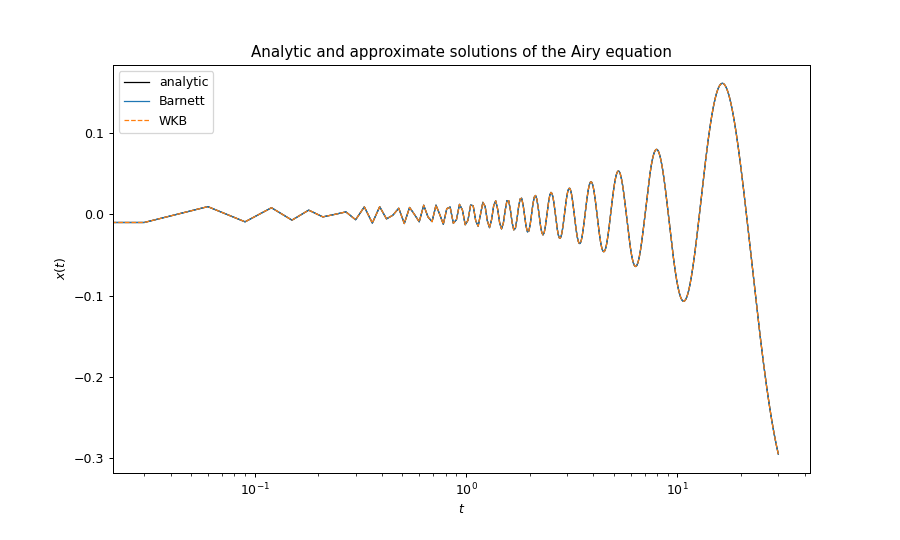

/cm/shared/sw/nix/store/mmjyg0figxiv63a170dvx7xjvr6jh21h-python-3.8.12-view/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/cm/shared/sw/nix/store/mmjyg0figxiv63a170dvx7xjvr6jh21h-python-3.8.12-view/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [327]:
%matplotlib notebook

plt.figure(figsize=(10,6))
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.title('Analytic and approximate solutions of the Airy equation')
plt.plot(ts, xs_ana, lw=1.0, label='analytic', color='black')
plt.semilogx(ts, xs_Barnett, lw=1.0, label='Barnett', color='C0')
plt.semilogx(ts, xs_WKB, '--', lw=1.0, label='WKB', color='C1')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


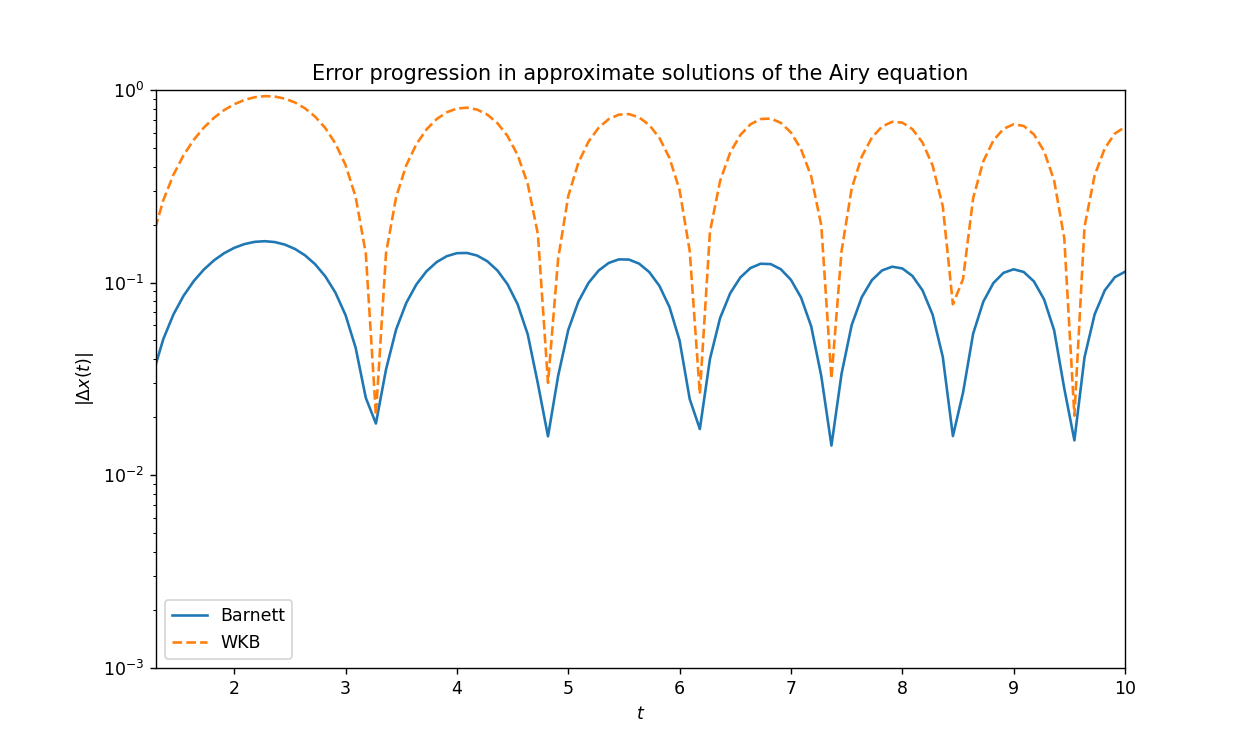

In [240]:
plt.figure(figsize=(10,6))
plt.xlabel('$t$')
plt.ylabel('$|\Delta x(t)|$')
plt.title('Error progression in approximate solutions of the Airy equation')
plt.semilogy(ts, err_Barnett, label='Barnett', color='C0')
plt.semilogy(ts, err_WKB, '--', label='WKB', color='C1')
plt.xlim((1.3, 10))
plt.ylim(1e-3, 1e0)
plt.legend()
plt.show()


In [6]:
%matplotlib notebook
def plot_Airy_x(n, ti, h, x0, N, real):
    
    ts = np.linspace(ti, ti+h, N)
    xs_ana = np.zeros(N, dtype=complex)
    dx0_ = 0.0
    if 'Ai' in x0:
        xs_ana += np.array([airy(-t_i)[0] for t_i in ts])
        dx0_ += -airy(-ts[0])[1]
    if 'Bi' in x0:
        xs_ana += np.array([1j*airy(-t_i)[2] for t_i in ts])
        dx0_ += -1j*airy(-ts[0])[3]
    x0_ = xs_ana[0]
    xs_Barnett = eval_Barnett(n, ts, x0_, dx0_)
    xs_WKB = eval_WKB(n, ts, x0_, dx0_)
    err_Barnett = np.abs(xs_Barnett - xs_ana)
    err_WKB = np.abs(xs_WKB - xs_ana)
    if real=='Im':
        xs_ana = xs_ana.imag
        xs_Barnett = xs_Barnett.imag
        xs_WKB = xs_WKB.imag

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,12))#, sharex=True)
    ax0.set_xlabel('$t$')
    ax0.set_ylabel('$x(t)$')
    ax0.set_title('Analytic and approximate solutions of the Airy equation, with $n={}$'.format(n))
    ax0.plot(ts, xs_ana, lw=1.0, label='analytic', color='black')
    ax0.plot(ts, xs_Barnett, lw=1.0, label='Barnett', color='C0')
    ax0.plot(ts, xs_WKB, '--', lw=1.0, label='WKB', color='C1')
    ax0.legend()
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$|\Delta x(t)|$')
    ax1.set_title('Error progression in approximate solutions of the Airy equation, with $n={}$'.format(n))
    # Cut off initial small error bit
    start = int(N/h)
    ts = ts[start:]
    err_Barnett = err_Barnett[start:]
    err_WKB = err_WKB[start:]
    ax1.semilogy(ts, err_Barnett, label='Barnett', color='C0')
    ax1.semilogy(ts, err_WKB, '--', label='WKB', color='C1')
    ax1.set_xlim((ti+1.0, ti+h))
    #plt.ylim(1e-5, 1e0)
    plt.legend()    
    plt.tight_layout()
    plt.show()
    
interactive_plot = widgets.interact(plot_Airy_x,
                 n=widgets.IntSlider(min=0, max=5, step=1, value=1),
                 ti=widgets.FloatSlider(min=1.0, max=1e3, step=1.0, value=1),
                 h=widgets.FloatSlider(min=10.0, max=100.0, step=1.0, value=10),
                 x0=widgets.SelectMultiple(options=['Ai', 'Bi'], disabled=False, value=['Ai'], rows=2),
                 N=widgets.IntSlider(min=100, max=1000, step=100, value=100),
                 real=widgets.RadioButtons(options=['Re', 'Im'], value='Re', description='Axis:', disabled=False),
                 continuous_update=False)
interactive_plot

interactive(children=(IntSlider(value=1, description='n', max=5), FloatSlider(value=1.0, description='ti', max…

<function __main__.plot_Airy_x(n, ti, h, x0, N, real)>

In [264]:
%matplotlib notebook
def plot_Airy_err(n, ti, h, x0, N):
    
    ts = np.linspace(ti, ti+h, N)
    xs_ana = np.zeros(N, dtype=complex)
    dx0_ = 0.0
    if 'Ai' in x0:
        xs_ana += np.array([airy(-t_i)[0] for t_i in ts])
        dx0_ += -airy(-ts[0])[1]
    if 'Bi' in x0:
        xs_ana += np.array([1j*airy(-t_i)[2] for t_i in ts])
        dx0_ += -1j*airy(-ts[0])[3]
    x0_ = xs_ana[0]
    xs_Barnett = eval_Barnett(n, ts, x0_, dx0_)
    xs_WKB = eval_WKB(n, ts, x0_, dx0_)
    err_Barnett = np.abs(xs_Barnett - xs_ana)
    err_WKB = np.abs(xs_WKB - xs_ana)
    
    plt.figure(figsize=(10,6))
    plt.xlabel('$t$')
    plt.ylabel('$|\Delta x(t)|$')
    plt.title('Error progression in approximate solutions of the Airy equation, with $n={}$'.format(n))
    plt.semilogy(ts, err_Barnett, label='Barnett', color='C0')
    plt.semilogy(ts, err_WKB, '--', label='WKB', color='C1')
    #plt.xlim((1.3, 10))
    #plt.ylim(1e-5, 1e0)
    plt.legend()
    plt.show()
    
interactive_plot = widgets.interact(plot_Airy_err,
                 n=widgets.IntSlider(min=0, max=5, step=1, value=1),
                 ti=widgets.FloatSlider(min=1.0, max=1e3, step=1.0, value=1),
                 h=widgets.FloatSlider(min=10.0, max=100.0, step=1.0, value=10),
                 x0=widgets.SelectMultiple(options=['Ai', 'Bi'], disabled=False, value=['Ai'], rows=2),
                 N=widgets.IntSlider(min=100, max=1000, step=100, value=100),
                 continuous_update=False)
interactive_plot

interactive(children=(IntSlider(value=1, description='n', max=5), FloatSlider(value=1.0, description='ti', max…

<function __main__.plot_Airy_err(n, ti, h, x0, N)>

In [19]:
S(0,t)

1.0*I*sqrt(t)

In [20]:
S(1,t)

1.0*I*sqrt(t) - 0.25/t

In [21]:
simplify(S(2,t))

(-0.75*t**(9/2) - 0.0234375*t**(3/2) + 1.0*I*t**6 - 0.03125*I*t**3)/(1.0*t**(11/2) - 0.0625*t**(5/2) + 0.5*I*t**4)

In [22]:
t.assumptions0

{'nonzero': True,
 'commutative': True,
 'imaginary': False,
 'zero': False,
 'extended_nonzero': True,
 'real': True,
 'complex': True,
 'infinite': False,
 'finite': True,
 'hermitian': True,
 'extended_real': True}

In [48]:
sum_S_wkb(0,t)

1.0*I*sqrt(t)

In [49]:
sum_S_wkb(1,t)

1.0*I*sqrt(t) - 0.25/t

In [50]:
sum_S_wkb(2, t)

1.0*I*sqrt(t) - 0.25/t + 0.15625*I/t**(5/2)

In [51]:
S_wkb(2, t)

0.15625*I/t**(5/2)